In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import torchvision
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as F

import transforms
import visualize

/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

## Dataset loading

In [3]:
dataroot = '../data/'

In [4]:
ds_train = torchvision.datasets.VOCSegmentation(root=dataroot, year="2012", image_set="train", download=False)

In [5]:
ds_train_v2 = torchvision.datasets.wrap_dataset_for_transforms_v2(ds_train)

In [6]:
tr_inv_norm = transforms.inv_normalize(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)

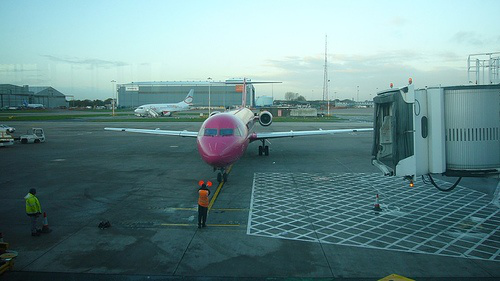

In [7]:
ds_train[0][0]

## Individual Transforms

In [8]:
def tensorinfo(t: torch.Tensor):
    info = "type=" + str(type(t))
    if not isinstance(t, torch.Tensor):
        return info
    
    info += "; dtype=" + str(t.dtype)
    info += "; shape=" + str(t.shape)
    info += "; minmax=" + str([t.min().item(), t.max().item()])
    return info

In [9]:
mean = transforms.PASCAL_VOC_2012_MEAN
std = transforms.PASCAL_VOC_2012_STD

In [10]:
input_sample = ds_train_v2[0]

In [11]:
img, mask = input_sample

In [12]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'PIL.Image.Image'>
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


In [13]:
tr = T.ToImageTensor()

In [14]:
img, mask = tr(input_sample)

In [15]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 281, 500]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


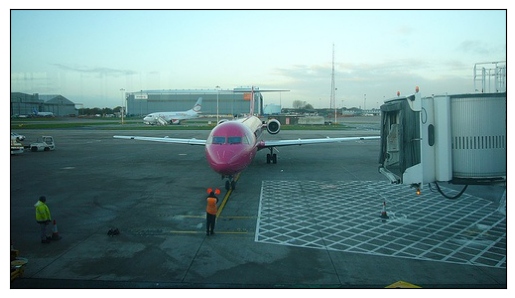

In [16]:
visualize.imshow_tensor(img)

### Clip superfluous mask classes (like boundary region)

Clip all classes higher than a maximum (20 for Pascal VOC) to be background.

In [17]:
tr = transforms.ClipMaskClasses(transforms.PASCAL_VOC_2012_CLASS_MAX)

In [18]:
tr_clipmask = tr

In [19]:
# save current sample state as starting point to show other transforms
input_sample = tr((img, mask))

In [20]:
img, mask = tr(input_sample)

In [21]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 281, 500]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 15]


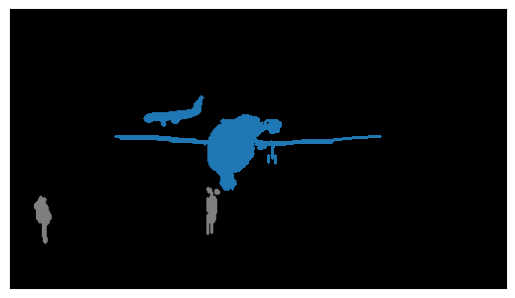

In [22]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

### Resize + Center crop

Maybe use for inference instead of RWP?

In [23]:
tr = T.Resize(256, antialias=True)

In [24]:
img, mask = tr(input_sample)

In [25]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 256, 455]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 455]); minmax=[0, 15]


In [26]:
input_sample[1].unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [27]:
mask.unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [28]:
tr = T.CenterCrop(256)

In [29]:
img, mask = tr((img, mask))

In [30]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 256, 256]); minmax=[3, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 256]); minmax=[0, 15]


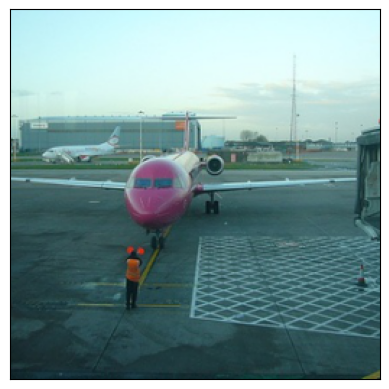

In [31]:
visualize.imshow_tensor(img)

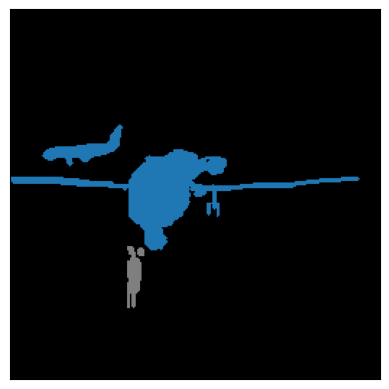

In [32]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

### Resize with pad

Applies to:
 - PIL
 - Tensor
 - Image
 - Mask

In [33]:
tr = transforms.Resize_with_pad(256,256)

In [34]:
img, mask = tr(input_sample)

In [35]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 256, 256]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 256]); minmax=[0, 15]


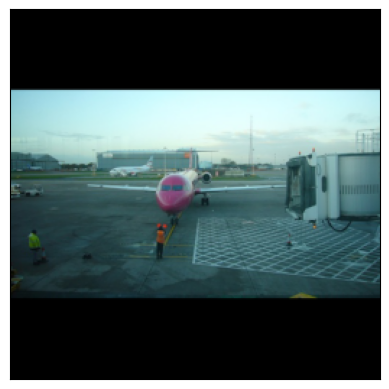

In [36]:
visualize.imshow_tensor(img)

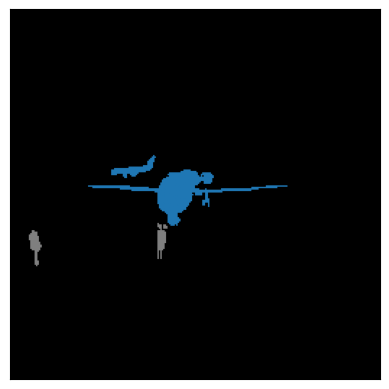

In [37]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

### Random Gaussian Blur

In [38]:
import torchvision.transforms.v2.functional as F


In [39]:
img = F.gaussian_blur(ds_train_v2[0][0], kernel_size=[5, 5], sigma=2)
mask = F.gaussian_blur(ds_train_v2[0][1], kernel_size=[5, 5], sigma=2)

In [40]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'PIL.Image.Image'>
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


In [41]:
input_sample[1].unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [42]:
mask.unique()

tensor([  0,   1,  15, 255], dtype=torch.uint8)

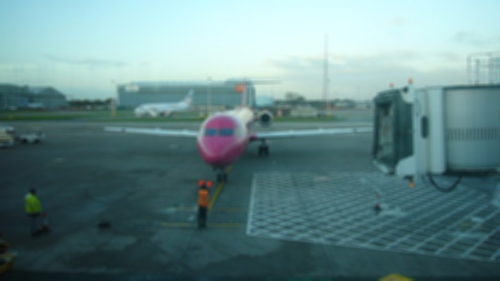

In [43]:
img

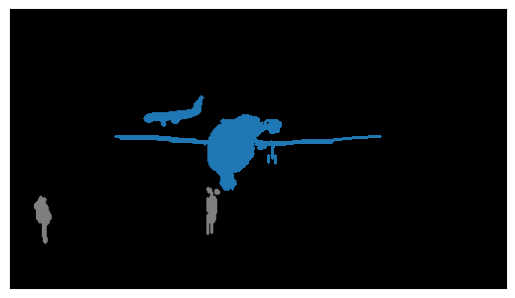

In [44]:
visualize.imshow_tensor(visualize.classmask_to_colormask(tr_clipmask(mask))[0,:])

### Random Resized Crop

In [45]:
tr = T.RandomResizedCrop(size=256, scale=(0.3, 1.0), ratio=(1,1), antialias=True)

In [46]:
img, mask = tr(input_sample)

In [47]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 256, 256]); minmax=[1, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 256]); minmax=[0, 15]


In [48]:
input_sample[1].unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [49]:
mask.unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [50]:
img

Image([[[176, 177, 177,  ..., 220, 220, 220],
        [176, 177, 178,  ..., 221, 220, 219],
        [177, 178, 178,  ..., 221, 221, 219],
        ...,
        [ 38,  38,  39,  ...,  91,  75,  61],
        [ 34,  32,  33,  ...,  86, 100, 100],
        [ 29,  28,  30,  ...,  26,  33,  46]],

       [[230, 231, 231,  ..., 255, 255, 255],
        [230, 231, 232,  ..., 255, 255, 255],
        [231, 232, 232,  ..., 255, 255, 255],
        ...,
        [ 62,  62,  63,  ..., 135, 119, 105],
        [ 58,  56,  57,  ..., 128, 143, 143],
        [ 53,  52,  54,  ...,  66,  73,  89]],

       [[240, 241, 241,  ..., 255, 255, 255],
        [240, 241, 242,  ..., 255, 255, 255],
        [241, 242, 242,  ..., 255, 255, 255],
        ...,
        [ 64,  64,  65,  ..., 144, 128, 114],
        [ 60,  58,  59,  ..., 137, 152, 152],
        [ 55,  54,  56,  ...,  74,  81,  95]]], dtype=torch.uint8, )

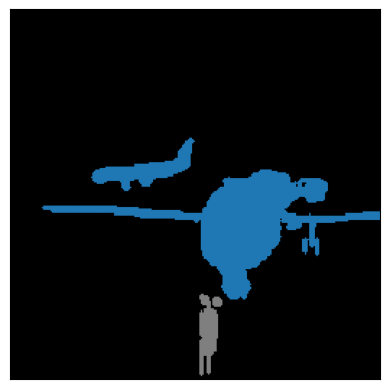

In [51]:
visualize.imshow_tensor(visualize.classmask_to_colormask(tr_clipmask(mask))[0,:])

### ColorJitter

In [52]:
# float dtype required for normalization
tr = T.ColorJitter(brightness=.3, hue=.2, contrast=.4, saturation=.3)

In [53]:
input_sample = ds_train_v2[0]

In [54]:
img, mask = tr(input_sample)

In [55]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'PIL.Image.Image'>
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


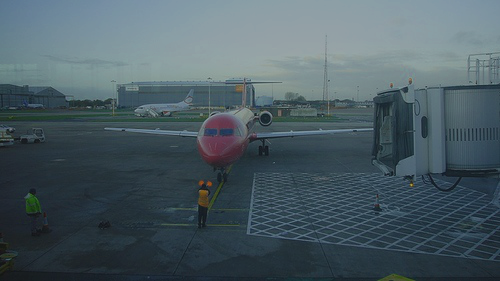

In [56]:
img

In [57]:
torch.std_mean(F.to_tensor(img), dim=(1,2))

/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_deprecated.py:27: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image_tensor(...)` followed by `convert_image_dtype(...)`.
  warnings.warn(


(tensor([0.1644, 0.1729, 0.1706]), tensor([0.2932, 0.3592, 0.3888]))

### Normalize

In [58]:
# float dtype required for normalization
tr = T.ConvertImageDtype(torch.float32)

In [59]:
img, mask = tr(input_sample)

In [60]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'PIL.Image.Image'>
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


In [61]:
tr = T.Normalize(mean=mean, std=std)

In [62]:
img, mask = tr((img, mask))

TypeError: Normalize() does not support PIL images.

In [ ]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

In [ ]:
torch.std_mean(img)

In [ ]:
# apply reverse normalization transform to properly display image
visualize.imshow_tensor(tr_inv_norm(img))

In [ ]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

## Composed Transforms

### Inference Transforms

In [ ]:
tr = transforms.make_transforms(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)

In [ ]:
input_sample = ds_train_v2[0]

In [ ]:
img, mask = tr(input_sample)

In [ ]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

In [ ]:
visualize.imshow_tensor(tr_inv_norm(img))

In [ ]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

### Training Transforms with augmentation

In [ ]:
tr = transforms.make_transforms(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD, augment_level=2)

In [ ]:
input_sample = ds_train_v2[0]

In [ ]:
img, mask = tr(input_sample)

In [ ]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

In [ ]:
visualize.imshow_tensor(tr_inv_norm(img))

In [ ]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

## Complete Dataset transforms

In [ ]:
import datasets

In [ ]:
ds_train, ds_val = datasets.make_datasets(datadir='../data/')

In [ ]:
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=8, shuffle=False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=8, shuffle=False)

In [ ]:
img, mask = next(iter(train_dataloader))

In [ ]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

In [ ]:
visualize.imshow_tensor(tr_inv_norm(img[0,:]))

In [ ]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask[:,0,:,:])[0])

In [ ]:
img, mask = next(iter(val_dataloader))

In [ ]:
visualize.imshow_tensor(tr_inv_norm(img[0,:]))

In [ ]:
mask.shape

In [ ]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask[:,0,:,:])[0])